### Import libraries

In [135]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [136]:
import tensorflow as tf
print(tf.__version__)

2.6.0


## Step 1: Data Exploration

In [137]:
# set variables 
main_folder = 'celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 1_000
VALIDATION_SAMPLES = int(TRAINING_SAMPLES * 0.2)
TEST_SAMPLES = int(TRAINING_SAMPLES * 0.1)
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_EPOCHS = 10

### Load the attributes of every picture

In [138]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [139]:
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


### List of the available attribute in the CelebA dataset

In [140]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


### Example of a picture in CelebA dataset
178 x 218 px

### Distribution of the Attribute

In [142]:
TARGET = 'Smiling'

In [143]:
df_attr[TARGET].value_counts(normalize=True)

0    0.51792
1    0.48208
Name: Smiling, dtype: float64

## Step 2: Split Dataset into Training, Validation and Test

In [144]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [145]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [146]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr[TARGET], how='inner')
df_par_attr.head()

,partition,Smiling
image_id,,
000001.jpg,0,1
000002.jpg,0,1
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


### 2.1: Generate Partitions (Train, Validation, Test)

In [147]:
def read_resize_image(image_file_name, batchdim=False):
    # read 
#     image = cv2.imread(image_file_name)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image =  load_img(image_file_name)
    image =  img_to_array(image)
    h, w, _ = image.shape
    
    # resize
    delta_h = int((IMG_HEIGHT - h) / 2)
    delta_w = int((IMG_WIDTH - w) / 2)
    image_corrected = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), int)
    image_corrected[delta_h: delta_h + h, delta_w: delta_w + w, :] = image
    
    # addition batch dimension
    if batchdim:
        image_corrected = image_corrected / 255.
        image_corrected = np.expand_dims(image_corrected, axis=0) # добавил размерность батрча
        
    return image_corrected

def plot_image(image):
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(image)

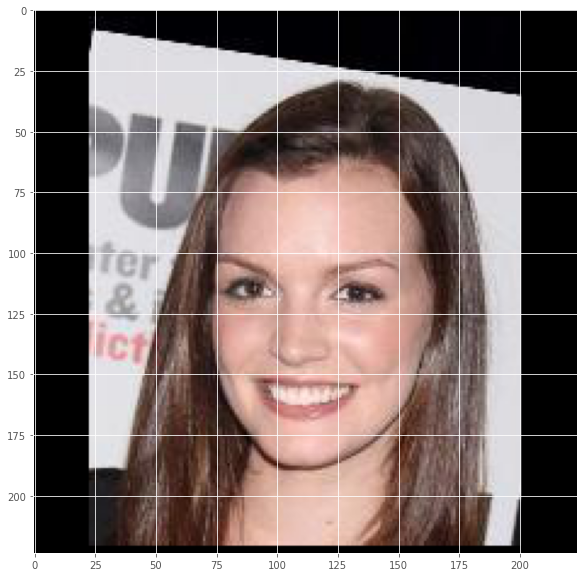

In [148]:
plot_image(read_resize_image(EXAMPLE_PIC))

In [149]:
def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test 
    '''
    
    # выбираем num_samples / 2 примерв с target = 0
    df_0 = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples / 2))
    
    # выбираем num_samples / 2 примерв с target = 1
    df_1 = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 1)].sample(int(num_samples / 2))

    df_ = pd.concat([df_0, df_1])


    # for Train and Validation
    if partition != 2:
        x_ = np.array([read_resize_image(images_folder + fname) for fname in df_.index])
        y_ = np_utils.to_categorical(df_[attr], 2) # превращает в [[1., 0.], [0., 1.], ...] # где [1., 0.] соответствует target = 0, [0., 1.] соответствет target = 1
    
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = read_resize_image(images_folder + index)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Step 3: Pre-processing Images: Data Augmentation

### 3.1. Let's start with an example: Data Augmentation

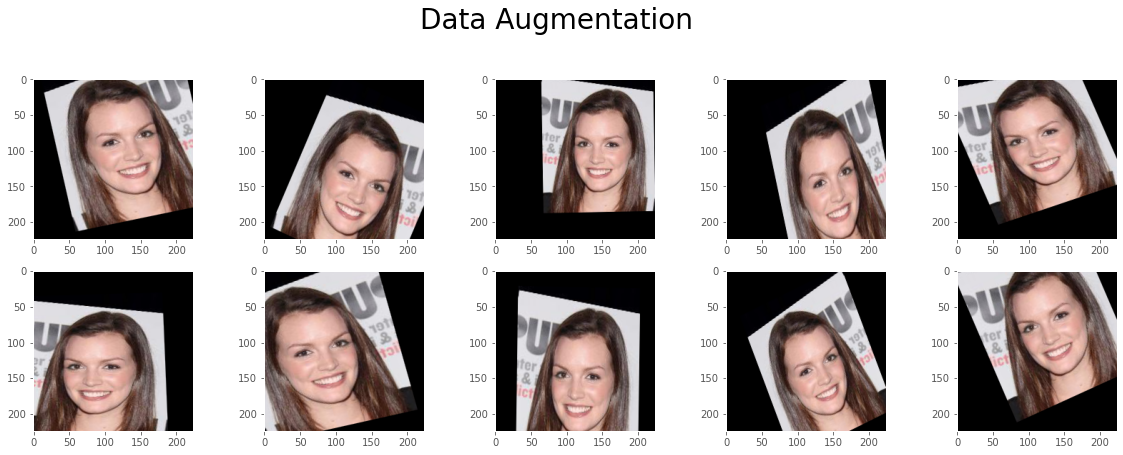

In [150]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = read_resize_image(EXAMPLE_PIC, batchdim=True)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

### 3.2. Build Data Generators

In [151]:
# Train data
x_train, y_train = generate_df(0, TARGET, TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
#   preprocessing_function=preprocess_input,
#   rotation_range=30,
#   width_shift_range=0.2,
#   height_shift_range=0.2,
#   shear_range=0.2,
#   zoom_range=0.2,
#   horizontal_flip=True,
)

train_datagen.fit(x_train)

In [152]:
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=BATCH_SIZE,
)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:862: UserWarning: The following variables cannot be serialized: train_generator
  warnings.warn(message)


In [153]:
# Validation Data
x_valid, y_valid = generate_df(1, TARGET, VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

## Step 4: Build the Model - Gender Recognition

### 4.1. Set the Model

In [154]:
model_mobnet = tf.keras.applications.mobilenet.MobileNet(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

In [155]:
print("number of layers:", len(model_mobnet.layers))

number of layers: 86


In [156]:
#Adding custom Layers
x = model_mobnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [157]:
# creating the final model 
model_ = Model(inputs=model_mobnet.input, outputs=predictions)

# # Lock initial layers to do not be trained
# for layer in model_.layers[:52]:
#     layer.trainable = False

# compile the model
model_.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 4.2. Train Model

In [158]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath=f'weights.best.inc.{TARGET}.h5', 
                               verbose=1, save_best_only=True)

In [159]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs=5
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
62/62 [==============================] - 79s 1s/step - loss: 0.6923 - accuracy: 0.7550 - val_loss: 5.9101 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 5.91009, saving model to weights.best.inc.Smiling.h5
Epoch 2/5
62/62 [==============================] - 78s 1s/step - loss: 0.2211 - accuracy: 0.9210 - val_loss: 3.4940 - val_accuracy: 0.5050

Epoch 00002: val_loss improved from 5.91009 to 3.49398, saving model to weights.best.inc.Smiling.h5
Epoch 3/5
62/62 [==============================] - 77s 1s/step - loss: 0.2238 - accuracy: 0.9200 - val_loss: 0.3854 - val_accuracy: 0.8850

Epoch 00003: val_loss improved from 3.49398 to 0.38545, saving model to weights.best.inc.Smiling.h5
Epoch 4/5
62/62 [==============================] - 76s 1s/step - loss: 0.1095 - accuracy: 0.9610 - val_loss: 2.5453 - val_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.38545
Epoch 5/5
62/62 [==============================] - 77s 1s/step - loss: 0.1132 - accuracy: 0.9

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:862: UserWarning: The following variables cannot be serialized: checkpointer, hist, model_, train_generator
  warnings.warn(message)


#### The best model after NUM_epech got an accuracy over the validation data of 95.75%.

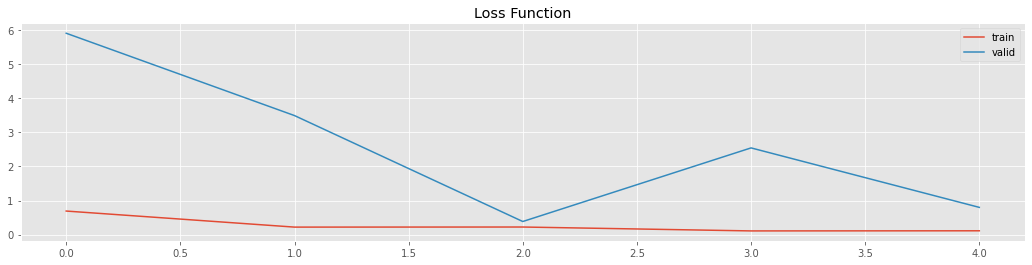

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:862: UserWarning: The following variables cannot be serialized: checkpointer, hist, model_
  warnings.warn(message)


In [160]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

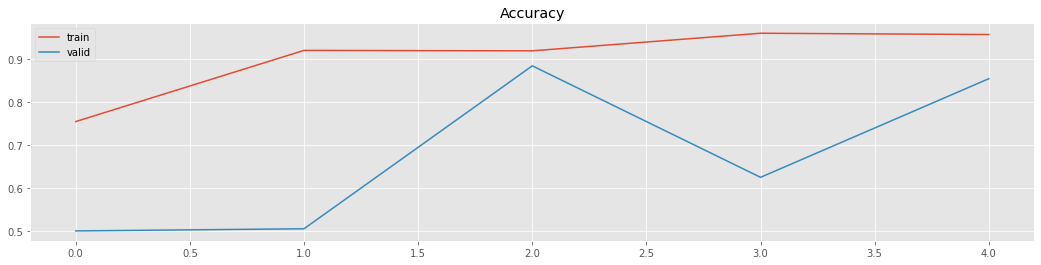

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:862: UserWarning: The following variables cannot be serialized: checkpointer, hist, model_
  warnings.warn(message)


In [165]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

### 4.3. Model Evaluation

In [168]:
#load the best model
model_.load_weights(f'weights.best.inc.{TARGET}.h5')

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:862: UserWarning: The following variables cannot be serialized: checkpointer, hist, model_
  warnings.warn(message)


In [169]:
# Test Data
x_test, y_test = generate_df(2, TARGET, TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:862: UserWarning: The following variables cannot be serialized: checkpointer, hist, model_
  warnings.warn(message)
